In [1]:
#IMPORTING OF USEFUL LIBRARIES IN THIS NOOTEBOOK
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
import datetime as dt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
pd.options.display.float_format = '{:.5f}'.format

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
#LOADIND OF FILES TO BE USED IN THIS CODE FROM ZINDI

#IGNORING THIRD LOAN DATA DUE TO HAVE LOW PERFORMANCE IN MODEL

#FILE FROM TRAINPERF & TRAINDEMOGRAPHICS
traindemographics = pd.read_csv('traindemographics.csv', parse_dates = ['birthdate'])
traindemographics['birthdate'].dt.strftime('%Y-%m-%d')
trainperf = pd.read_csv('trainperf.csv', parse_dates = ['approveddate', 'creationdate'])
trainperf.drop('approveddate',inplace=True, axis = 1)
trainperf.drop('creationdate',inplace=True, axis = 1)

#TRAIN FILES CONTAINING PREVIOUS LOANS INFORMATION

trainprevloans = pd.read_csv('trainprevloans.csv', parse_dates = ['approveddate','creationdate','closeddate','firstduedate','firstrepaiddate'])
trainprevloans['approveddate'].dt.strftime('%Y-%m-%d')
trainprevloans['creationdate'].dt.strftime('%Y-%m-%d')
trainprevloans['closeddate'].dt.strftime('%Y-%m-%d')
trainprevloans['firstduedate'].dt.strftime('%Y-%m-%d')
trainprevloans['firstrepaiddate'].dt.strftime('%Y-%m-%d')

#TEST FILES CONTAINING DEMOGRAPHICS INFORMATION 

testdemographics = pd.read_csv('testdemographics.csv', parse_dates = ['birthdate'])
testdemographics['birthdate'].dt.strftime('%Y-%m-%d')
testperf = pd.read_csv('testperf.csv', parse_dates = ['approveddate','creationdate'])
testperf.drop('approveddate',inplace=True, axis = 1)
testperf.drop('creationdate',inplace=True, axis = 1)

#TEST FILES CONTAINING PREVIOUS LOAN INFORMATION

testprevloans = pd.read_csv('testprevloans.csv', parse_dates = ['approveddate','creationdate','closeddate','firstduedate','firstrepaiddate'])
testprevloans['approveddate'].dt.strftime('%Y-%m-%d')
testprevloans['creationdate'].dt.strftime('%Y-%m-%d')
testprevloans['closeddate'].dt.strftime('%Y-%m-%d')
testprevloans['firstduedate'].dt.strftime('%Y-%m-%d')
testprevloans['firstrepaiddate'].dt.strftime('%Y-%m-%d')

# Preview train dataset
traindemographics['age'] =(pd.to_datetime('today') - pd.to_datetime(traindemographics["birthdate"])) / pd.to_timedelta('1day')
testdemographics['age'] =(pd.to_datetime('today') - pd.to_datetime(testdemographics["birthdate"])) / pd.to_timedelta('1day')

trainprevloans['age_paid'] =(pd.to_datetime(trainprevloans["closeddate"]) - pd.to_datetime(trainprevloans["firstrepaiddate"])) / pd.to_timedelta('1min')
testprevloans['age_paid'] =(pd.to_datetime(testprevloans["closeddate"]) - pd.to_datetime(testprevloans["firstrepaiddate"]) ) / pd.to_timedelta('1min')

trainprevloans['age_due'] =(pd.to_datetime(trainprevloans["closeddate"]) - pd.to_datetime(trainprevloans["firstduedate"])) / pd.to_timedelta('1min')
testprevloans['age_due'] =( pd.to_datetime(testprevloans["closeddate"]) - pd.to_datetime(testprevloans["firstduedate"])) / pd.to_timedelta('1min')

trainprevloans['loanamount_x']= trainprevloans['loanamount']
testprevloans['loanamount_x']= testprevloans['loanamount']

trainprevloans['totaldue_x']= trainprevloans['totaldue']
testprevloans['totaldue_x']= testprevloans['totaldue']

trainprevloans['termdays_x']= trainprevloans['termdays']
testprevloans['termdays_x']= testprevloans['termdays']

trainprevloans['loannumber_x']= trainprevloans['loannumber']
testprevloans['loannumber_x']= testprevloans['loannumber']

trainperf["first_previous_loanamount"]=0 
trainperf["first_previous_totaldue"]=0 
trainperf["first_previous_age_paid"]=0 
trainperf["first_previous_age_due"]=0 
trainperf["first_previous_termdays"]=0 
trainperf["first_previous_loannumber"]=0
trainperf["first_diff_loanamount"]=0

trainperf["second_previous_loanamount"]=0 
trainperf["second_previous_totaldue"]=0 
trainperf["second_previous_age_paid"]=0 
trainperf["second_previous_age_due"]=0 
trainperf["second_previous_termdays"]=0 
trainperf["second_previous_loannumber"]=0
trainperf["second_diff_loanamount"]=0


testperf["first_previous_loanamount"]=0 
testperf["first_previous_totaldue"]=0
testperf["first_previous_age_paid"]=0 
testperf["first_previous_age_due"]=0 
testperf["first_previous_termdays"]=0 
testperf["first_previous_loannumber"]=0
testperf["first_diff_loanamount"]=0

testperf["second_previous_loanamount"]=0 
testperf["second_previous_totaldue"]=0 
testperf["second_previous_age_paid"]=0 
testperf["second_previous_age_due"]=0 
testperf["second_previous_termdays"]=0 
testperf["second_previous_loannumber"]=0
testperf["second_diff_loanamount"]=0

row_count=0
#just save column names to list and convert dataframe to numpy array
column = list(trainperf.columns)
trainperf_ = trainperf.values

column_prev = list(trainprevloans.columns)
trainprevloans_ = trainprevloans.values
for row in trainperf_:
    cnt = 0
    for row_prev in trainprevloans_:
        if row[column.index('customerid')] == row_prev[column_prev.index('customerid')]:
            if cnt ==0:
                trainperf.at[row_count,'first_previous_loanamount'] = row_prev[column_prev.index('loanamount')]
                trainperf.at[row_count,'first_previous_totaldue'] = row_prev[column_prev.index('totaldue') ]
                trainperf.at[row_count,'first_previous_age_paid'] = row_prev[column_prev.index('age_paid') ]
                trainperf.at[row_count,'first_previous_age_due'] = row_prev[column_prev.index('age_due') ]
                trainperf.at[row_count,'first_previous_termdays'] = row_prev[column_prev.index('termdays') ]
                trainperf.at[row_count,'first_previous_loannumber'] = row_prev[column_prev.index('loannumber') ]
                cnt+=1
            elif cnt == 1:
                trainperf.at[row_count,'second_previous_loanamount'] = row_prev[column_prev.index('loanamount')]
                trainperf.at[row_count,'second_previous_totaldue'] = row_prev[column_prev.index('totaldue') ]
                trainperf.at[row_count,'second_previous_age_paid'] = row_prev[column_prev.index('age_paid') ]
                trainperf.at[row_count,'second_previous_age_due'] = row_prev[column_prev.index('age_due') ]
                trainperf.at[row_count,'second_previous_termdays'] = row_prev[column_prev.index('termdays') ]
                trainperf.at[row_count,'second_previous_loannumber'] = row_prev[column_prev.index('loannumber') ]
                cnt+=1
                break
            elif cnt == 2:
                trainperf.at[row_count,'third_previous_loanamount'] = row_prev[column_prev.index('loanamount')]
                trainperf.at[row_count,'third_previous_totaldue'] = row_prev[column_prev.index('totaldue') ]
                trainperf.at[row_count,'third_previous_age_paid'] = row_prev[column_prev.index('age_paid') ]
                trainperf.at[row_count,'third_previous_age_due'] = row_prev[column_prev.index('age_due') ]
                trainperf.at[row_count,'third_previous_termdays'] = row_prev[column_prev.index('termdays') ]
                trainperf.at[row_count,'third_previous_loannumber'] = row_prev[column_prev.index('loannumber') ]
                cnt+=1
                break
    row_count+=1
                                                                          
row_count=0

#just save column names to list and convert dataframe to numpy array
column = list(testperf.columns)
testperf_ = testperf.values
column_prev = list(testprevloans.columns)
testprevloans_ = testprevloans.values

for row in testperf_:
    cnt = 0
    for row_prev in testprevloans_:
        if row[column.index('customerid')] == row_prev[column_prev.index('customerid')]:
            if cnt ==0:
                testperf.at[row_count,'first_previous_loanamount'] = row_prev[column_prev.index('loanamount')]
                testperf.at[row_count,'first_previous_totaldue'] = row_prev[column_prev.index('totaldue') ]
                testperf.at[row_count,'first_previous_age_paid'] = row_prev[column_prev.index('age_paid') ]
                testperf.at[row_count,'first_previous_age_due'] = row_prev[column_prev.index('age_due') ]
                testperf.at[row_count,'first_previous_termdays'] = row_prev[column_prev.index('termdays') ]
                testperf.at[row_count,'first_previous_loannumber'] = row_prev[column_prev.index('loannumber') ]
                cnt+=1
            elif cnt == 1:
                testperf.at[row_count,'second_previous_loanamount'] = row_prev[column_prev.index('loanamount')]
                testperf.at[row_count,'second_previous_totaldue'] = row_prev[column_prev.index('totaldue') ]
                testperf.at[row_count,'second_previous_age_paid'] = row_prev[column_prev.index('age_paid') ]
                testperf.at[row_count,'second_previous_age_due'] = row_prev[column_prev.index('age_due') ]
                testperf.at[row_count,'second_previous_termdays'] = row_prev[column_prev.index('termdays') ]
                testperf.at[row_count,'second_previous_loannumber'] = row_prev[column_prev.index('loannumber') ]
                cnt+=1
                break
            elif cnt == 2:
                testperf.at[row_count,'third_previous_loanamount'] = row_prev[column_prev.index('loanamount')]
                testperf.at[row_count,'third_previous_totaldue'] = row_prev[column_prev.index('totaldue') ]
                testperf.at[row_count,'third_previous_age_paid'] = row_prev[column_prev.index('age_paid') ]
                testperf.at[row_count,'third_previous_age_due'] = row_prev[column_prev.index('age_due') ]
                testperf.at[row_count,'third_previous_termdays'] = row_prev[column_prev.index('termdays') ]
                testperf.at[row_count,'third_previous_loannumber'] = row_prev[column_prev.index('loannumber') ]
                cnt+=1
                break       
    row_count+=1

trainperf.tail(2)

,customerid,systemloanid,loannumber,loanamount,totaldue,termdays,referredby,good_bad_flag,first_previous_loanamount,first_previous_totaldue,...,first_previous_termdays,first_previous_loannumber,first_diff_loanamount,second_previous_loanamount,second_previous_totaldue,second_previous_age_paid,second_previous_age_due,second_previous_termdays,second_previous_loannumber,second_diff_loanamount
4366,8a858f935ca09667015ca0ee3bc63f51,301977679,2,10000.00000,13000.00000,30,8a858eda5c8863ff015c9dead65807bb,Bad,10000,13000,...,30,1,0,0,0,0,0,0,0,0
4367,8a858fd458639fcc015868eb14b542ad,301967124,8,30000.00000,34500.00000,30,NaN,Bad,30000,34500,...,30,7,0,10000,13000,15,-792,30,3,0


In [3]:
testperf.tail(2)

,customerid,systemloanid,loannumber,loanamount,totaldue,termdays,referredby,first_previous_loanamount,first_previous_totaldue,first_previous_age_paid,...,first_previous_termdays,first_previous_loannumber,first_diff_loanamount,second_previous_loanamount,second_previous_totaldue,second_previous_age_paid,second_previous_age_due,second_previous_termdays,second_previous_loannumber,second_diff_loanamount
1448,8a858e10570f2d65015717fcfec44996,301961483,14,60000,68100.00000,90,NaN,20000,23800,15,...,30,5,0,50000,57500,10,-4786,90,12,0
1449,8a858f605b911d60015b91b99d55400d,301973097,6,20000,22250.00000,15,8a858ff259d1429e0159d2d0194c4b8e,10000,11500,15,...,15,1,0,10000,11125,10,1375,15,4,0


In [4]:
#FEATURE ENGINEERING OF DATA TO ORGANIZE IN A MANNER CAN BE EASIER USED
trainperf["first_second_loandiff"]=0
trainperf["first_diff_loanamount"] = trainperf["loanamount"] - trainperf["first_previous_loanamount"]
trainperf["second_diff_loanamount"] = trainperf["loanamount"] - trainperf["second_previous_loanamount"]
trainperf["first_second_loandiff"] = trainperf["first_previous_loanamount"] - trainperf["second_previous_loanamount"]
testperf["first_second_loandiff"]=0
testperf["first_diff_loanamount"] = testperf["loanamount"] - testperf["first_previous_loanamount"]
testperf["second_diff_loanamount"] = testperf["loanamount"] - testperf["second_previous_loanamount"]
testperf["first_second_loandiff"] = testperf["first_previous_loanamount"] - testperf["second_previous_loanamount"]
trainperf["loan_interest"]=0
trainperf["first_loan_interest"]=0
trainperf["second_loan_interest"]=0
trainperf["loaninterest_avg"]=0
trainperf["loaninterest_std"]=0
trainperf["loan_interest"] = trainperf["totaldue"] - trainperf["loanamount"] 
trainperf["first_loan_interest"] = trainperf["first_previous_totaldue"] - trainperf["first_previous_loanamount"]
trainperf["second_loan_interest"] = trainperf["second_previous_totaldue"] - trainperf["second_previous_loanamount"]
trainperf["loaninterest_avg"]= trainperf[['loan_interest','first_loan_interest','second_loan_interest']].mean(axis=1)
trainperf["loaninterest_std"]= trainperf[['loan_interest','first_loan_interest','second_loan_interest']].std(axis=1)
testperf["loan_interest"]=0
testperf["first_loan_interest"]=0
testperf["second_loan_interest"]=0
testperf["loaninterest_avg"]=0
testperf["loaninterest_std"]=0
testperf["loan_interest"]= testperf["totaldue"] - testperf["loanamount"] 
testperf["first_loan_interest"] = testperf["first_previous_totaldue"] - testperf["first_previous_loanamount"] 
testperf["second_loan_interest"] = testperf["second_previous_totaldue"] - testperf["second_previous_loanamount"]
testperf["loaninterest_avg"]= testperf[['loan_interest','first_loan_interest','second_loan_interest']].mean(axis=1)
testperf["loaninterest_std"]= testperf[['loan_interest','first_loan_interest','second_loan_interest']].std(axis=1)
trainperf["loanamount_avg"]=0
trainperf["totaldue_avg"]=0
trainperf["loanamount_std"]=0
trainperf["totaldue_std"]=0
trainperf["loanamount_avg"]= trainperf[['loanamount','first_previous_loanamount','second_previous_loanamount']].mean(axis=1)
trainperf["totaldue_avg"]= trainperf[['totaldue','first_previous_totaldue','second_previous_totaldue']].mean(axis=1)
trainperf["loanamount_std"]= trainperf[['loanamount','first_previous_loanamount','second_previous_loanamount']].std(axis=1)
trainperf["totaldue_std"]= trainperf[['totaldue','first_previous_totaldue','second_previous_totaldue']].std(axis=1)
testperf["loanamount_avg"]=0
testperf["totaldue_avg"]=0
testperf["loanamount_std"]=0
testperf["totaldue_std"]=0
testperf["loanamount_avg"]= testperf[['loanamount','first_previous_loanamount','second_previous_loanamount']].mean(axis=1)
testperf["totaldue_avg"]= testperf[['totaldue','first_previous_totaldue','second_previous_totaldue']].mean(axis=1)
testperf["loanamount_std"]= testperf[['loanamount','first_previous_loanamount','second_previous_loanamount']].std(axis=1)
testperf["totaldue_std"]= testperf[['totaldue','first_previous_totaldue','second_previous_totaldue']].std(axis=1)

#FILE OF ARRANGED DATA AFTER FEATURED THEM
trainperf.to_csv('trainperf_new.csv') 
testperf.to_csv('testperf_new.csv') 

In [5]:
#FINDING THOSE WHO TAKING LOAN
trainperf.query('first_previous_loanamount > 0')

,customerid,systemloanid,loannumber,loanamount,totaldue,termdays,referredby,good_bad_flag,first_previous_loanamount,first_previous_totaldue,...,first_second_loandiff,loan_interest,first_loan_interest,second_loan_interest,loaninterest_avg,loaninterest_std,loanamount_avg,totaldue_avg,loanamount_std,totaldue_std
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,30000.00000,34500.00000,30,NaN,Good,10000,13000,...,0,4500.00000,3000,3000,3500.00000,866.02540,16666.66667,20166.66667,11547.00538,12413.03079
2,8a8588f35438fe12015444567666018e,301966580,7,20000.00000,22250.00000,15,NaN,Good,10000,11500,...,0,2250.00000,1500,1500,1750.00000,433.01270,13333.33333,15083.33333,5773.50269,6206.51539
3,8a85890754145ace015429211b513e16,301999343,3,10000.00000,11500.00000,15,NaN,Good,10000,11500,...,0,1500.00000,1500,3000,2000.00000,866.02540,10000.00000,12000.00000,0.00000,866.02540
4,8a858970548359cc0154883481981866,301962360,9,40000.00000,44000.00000,30,NaN,Good,20000,23800,...,-10000,4000.00000,3800,9000,5600.00000,2946.18397,30000.00000,35600.00000,10000.00000,10520.45626
5,8a8589f35451855401546b0738c42524,301986516,8,30000.00000,39000.00000,60,NaN,Good,20000,24500,...,10000,9000.00000,4500,3000,5500.00000,3122.49900,20000.00000,25500.00000,10000.00000,13028.81422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4363,8a858e6d58b0cc520158beeb14b22a5a,302003163,2,10000.00000,13000.00000,30,NaN,Bad,10000,13000,...,10000,3000.00000,3000,0,2000.00000,1732.05081,6666.66667,8666.66667,5773.50269,7505.55350
4364,8a858ee85cf400f5015cf44ab1c42d5c,301998967,2,10000.00000,13000.00000,30,NaN,Bad,10000,13000,...,10000,3000.00000,3000,0,2000.00000,1732.05081,6666.66667,8666.66667,5773.50269,7505.55350
4365,8a858f365b2547f3015b284597147c94,301995576,3,10000.00000,11500.00000,15,NaN,Bad,10000,11500,...,0,1500.00000,1500,1500,1500.00000,0.00000,10000.00000,11500.00000,0.00000,0.00000
4366,8a858f935ca09667015ca0ee3bc63f51,301977679,2,10000.00000,13000.00000,30,8a858eda5c8863ff015c9dead65807bb,Bad,10000,13000,...,10000,3000.00000,3000,0,2000.00000,1732.05081,6666.66667,8666.66667,5773.50269,7505.55350


In [6]:
testperf.query('first_previous_loanamount > 0')

,customerid,systemloanid,loannumber,loanamount,totaldue,termdays,referredby,first_previous_loanamount,first_previous_totaldue,first_previous_age_paid,...,first_second_loandiff,loan_interest,first_loan_interest,second_loan_interest,loaninterest_avg,loaninterest_std,loanamount_avg,totaldue_avg,loanamount_std,totaldue_std
0,8a858899538ddb8e015390510b321f08,301998974,4,10000,12250.00000,30,NaN,10000,13000,500,...,4000,2250.00000,3000,900,2050.00000,1064.18983,8666.66667,10716.66667,2309.40108,3326.53473
1,8a858959537a097401537a4e316e25f7,301963615,10,40000,44000.00000,30,NaN,30000,36800,15,...,0,4000.00000,6800,4400,5066.66667,1514.37556,33333.33333,38400.00000,5773.50269,4995.99840
2,8a8589c253ace09b0153af6ba58f1f31,301982236,6,20000,24500.00000,30,NaN,10000,13000,15,...,0,4500.00000,3000,1500,3000.00000,1500.00000,13333.33333,16333.33333,5773.50269,7112.19610
3,8a858e095aae82b7015aae86ca1e030b,301971730,8,30000,34500.00000,30,NaN,20000,22250,10,...,0,4500.00000,2250,1900,2883.33333,1410.96893,23333.33333,26216.66667,5773.50269,7175.71135
4,8a858e225a28c713015a30db5c48383d,301959177,4,20000,24500.00000,30,NaN,10000,13000,10,...,0,4500.00000,3000,3000,3500.00000,866.02540,13333.33333,16833.33333,5773.50269,6639.52810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1445,8a858fb45bb59c21015bb88a191f58f2,301991141,3,10000,11500.00000,15,NaN,10000,11500,10,...,0,1500.00000,1500,1500,1500.00000,0.00000,10000.00000,11500.00000,0.00000,0.00000
1446,8a858fcb5b00cc54015b0253ced26a5f,301963018,3,10000,13000.00000,30,NaN,10000,11500,31,...,0,3000.00000,1500,1500,2000.00000,866.02540,10000.00000,12000.00000,0.00000,866.02540
1447,8a858fde56eb02280156f59b976d46c0,301994653,9,40000,48000.00000,60,NaN,25000,29000,15,...,15000,8000.00000,4000,3000,5000.00000,2645.75131,25000.00000,30000.00000,15000.00000,17521.41547
1448,8a858e10570f2d65015717fcfec44996,301961483,14,60000,68100.00000,90,NaN,20000,23800,15,...,-30000,8100.00000,3800,7500,6466.66667,2328.80513,43333.33333,49800.00000,20816.65999,23132.01245


In [7]:
# let's have a look at how many labels

for col in trainperf.columns[0:]:
    print(col, ': ', len(trainperf[col].unique()), ' labels')
print("-------LOAN----------------------")
for col in testperf.columns[0:]:
    print(col, ': ', len(testperf[col].unique()), ' labels')

customerid :  4368  labels
systemloanid :  4368  labels
loannumber :  23  labels
loanamount :  10  labels
totaldue :  47  labels
termdays :  4  labels
referredby :  522  labels
good_bad_flag :  2  labels
first_previous_loanamount :  15  labels
first_previous_totaldue :  68  labels
first_previous_age_paid :  295  labels
first_previous_age_due :  3821  labels
first_previous_termdays :  5  labels
first_previous_loannumber :  19  labels
first_diff_loanamount :  21  labels
second_previous_loanamount :  13  labels
second_previous_totaldue :  63  labels
second_previous_age_paid :  296  labels
second_previous_age_due :  2636  labels
second_previous_termdays :  5  labels
second_previous_loannumber :  19  labels
second_diff_loanamount :  23  labels
first_second_loandiff :  30  labels
loan_interest :  30  labels
first_loan_interest :  50  labels
second_loan_interest :  47  labels
loaninterest_avg :  298  labels
loaninterest_std :  422  labels
loanamount_avg :  40  labels
totaldue_avg :  586  labe

In [8]:
traindemographics.head(2)

,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients,age
0,8a858e135cb22031015cbafc76964ebd,1973-10-10,Savings,3.31922,6.52860,GT Bank,NaN,NaN,NaN,17721.79483
1,8a858e275c7ea5ec015c82482d7c3996,1986-01-21,Savings,3.32560,7.11940,Sterling Bank,NaN,Permanent,NaN,13235.79483


In [9]:
#CHECKING LABELES
for col in traindemographics.columns[0:]:
    print(col, ': ', len(traindemographics[col].unique()), ' labels')

customerid :  4334  labels
birthdate :  3297  labels
bank_account_type :  3  labels
longitude_gps :  4103  labels
latitude_gps :  4313  labels
bank_name_clients :  18  labels
bank_branch_clients :  46  labels
employment_status_clients :  7  labels
level_of_education_clients :  5  labels
age :  3297  labels


In [10]:
#CHECKING CUSTOMERS
customer_present=0
customer_not_present=0
for customerid in trainperf['customerid']:
    #print(customerid)
    if customerid in traindemographics['customerid'].values:
        customer_present +=1
    else:
        customer_not_present +=1
customer_present, customer_not_present

(3269, 1099)

In [11]:
customer_present=0
customer_not_present=0
for customerid in testperf['customerid']:
    #print(customerid)
    if customerid in testdemographics['customerid'].values:
        customer_present +=1
    else:
        customer_not_present +=1
customer_present, customer_not_present

(385, 1065)

In [12]:
print(trainprevloans.shape,traindemographics.shape, trainperf.shape)

traindemographics = traindemographics.drop_duplicates()
trainprevloans = trainprevloans.drop_duplicates()
trainperf = trainperf.drop_duplicates()

print(trainprevloans.shape,traindemographics.shape, trainperf.shape)



(18183, 18) (4346, 10) (4368, 32)
(18183, 18) (4334, 10) (4368, 32)


In [13]:
print(testprevloans.shape,testdemographics.shape, testperf.shape)

testdemographics = testdemographics.drop_duplicates()
testprevloans = testprevloans.drop_duplicates()
testperf = testperf.drop_duplicates()

print(testprevloans.shape,testdemographics.shape, testperf.shape)

(5907, 18) (1487, 10) (1450, 31)
(5907, 18) (1484, 10) (1450, 31)


In [14]:
test_data = testperf.copy()
print(test_data.shape)
test_data = test_data.drop_duplicates('customerid')
print(test_data.shape)

(1450, 31)
(1450, 31)


In [15]:
train_data=trainperf.copy()
print(train_data.shape)
train_data = train_data.drop_duplicates('customerid')
print(train_data.shape)

(4368, 32)
(4368, 32)


In [16]:
train_data.loc[train_data['referredby'].isnull(),'referredby_num'] = 0
train_data.loc[train_data['referredby'].notnull(), 'referredby_num'] = 1
test_data.loc[test_data['referredby'].isnull(),'referredby_num'] = 0
test_data.loc[test_data['referredby'].notnull(), 'referredby_num'] = 1
train_data=train_data.drop(['referredby'], axis = 1)
test_data=test_data.drop(['referredby'], axis = 1)
train_data=train_data.drop(['systemloanid'], axis = 1)
test_data=test_data.drop(['systemloanid'], axis = 1)

#CHANGING DATA TO CATEGORIES
for col in ['termdays',  'first_previous_termdays', 'second_previous_termdays']:
    train_data[col] = train_data[col].astype('category')
    test_data[col] = test_data[col].astype('category')
train_data['good_bad_flag'] = train_data['good_bad_flag'].astype('category')

In [17]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4368 entries, 0 to 4367
Data columns (total 31 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   customerid                  4368 non-null   object  
 1   loannumber                  4368 non-null   int64   
 2   loanamount                  4368 non-null   float64 
 3   totaldue                    4368 non-null   float64 
 4   termdays                    4368 non-null   category
 5   good_bad_flag               4368 non-null   category
 6   first_previous_loanamount   4368 non-null   int64   
 7   first_previous_totaldue     4368 non-null   int64   
 8   first_previous_age_paid     4368 non-null   int64   
 9   first_previous_age_due      4368 non-null   int64   
 10  first_previous_termdays     4368 non-null   category
 11  first_previous_loannumber   4368 non-null   int64   
 12  first_diff_loanamount       4368 non-null   float64 
 13  second_previous_lo

In [18]:
test_data.describe()

,loannumber,loanamount,totaldue,first_previous_loanamount,first_previous_totaldue,first_previous_age_paid,first_previous_age_due,first_previous_loannumber,first_diff_loanamount,second_previous_loanamount,...,loan_interest,first_loan_interest,second_loan_interest,loaninterest_avg,loaninterest_std,loanamount_avg,totaldue_avg,loanamount_std,totaldue_std,referredby_num
count,1450.00000,1450.00000,1450.00000,1450.00000,1450.00000,1450.00000,1450.00000,1450.00000,1450.00000,1450.00000,...,1450.00000,1450.00000,1450.00000,1450.00000,1450.00000,1450.00000,1450.00000,1450.00000,1450.00000,1450.00000
mean,5.08897,17482.75862,20874.66407,12704.13793,15430.33586,516.53448,-1154.36069,2.56828,4778.62069,9603.44828,...,3391.90545,2726.19793,1966.51655,2694.87331,1133.02940,13263.44828,15958.32159,5491.71490,6529.73102,0.12690
std,3.66521,10585.42003,11726.58463,6685.07165,7514.24226,3878.04182,22615.65838,2.49274,8069.22847,9241.67440,...,1604.99710,1143.18230,1736.44714,1166.56826,795.06074,7685.93245,8639.29315,4248.67247,4727.92088,0.33297
min,2.00000,10000.00000,10500.00000,0.00000,0.00000,0.00000,-90296.00000,0.00000,-30000.00000,0.00000,...,500.00000,0.00000,0.00000,500.00000,0.00000,3333.33333,3833.33333,0.00000,0.00000,0.00000
25%,2.00000,10000.00000,13000.00000,10000.00000,11500.00000,10.00000,-7280.75000,1.00000,0.00000,0.00000,...,2500.00000,1500.00000,0.00000,2000.00000,593.74021,6666.66667,8666.66667,2886.75135,3103.25770,0.00000
50%,4.00000,10000.00000,13000.00000,10000.00000,13000.00000,10.00000,-1935.50000,2.00000,0.00000,10000.00000,...,3000.00000,3000.00000,1500.00000,2500.00000,866.02540,10000.00000,13000.00000,5773.50269,6853.73597,0.00000
75%,7.00000,20000.00000,24500.00000,10000.00000,13000.00000,15.00000,1002.75000,3.00000,10000.00000,10000.00000,...,4500.00000,3000.00000,3000.00000,3500.00000,1732.05081,16666.66667,20166.66667,5773.50269,7505.55350,0.00000
max,34.00000,60000.00000,68100.00000,50000.00000,57500.00000,47812.00000,529252.00000,31.00000,50000.00000,50000.00000,...,9000.00000,8000.00000,9000.00000,7600.00000,5196.15242,46666.66667,54033.50000,28867.51346,30253.15411,1.00000


In [20]:
#DISPLAYING LABELES

for col in train_data.columns[0:]:
    print(col, ': ', len(train_data[col].unique()), ' labels')
print("-------------------------TEST DATA-----------------------------")
for col in test_data.columns[0:]:
    print(col, ': ', len(test_data[col].unique()), ' labels')

customerid :  4368  labels
loannumber :  23  labels
loanamount :  10  labels
totaldue :  47  labels
termdays :  4  labels
good_bad_flag :  2  labels
first_previous_loanamount :  15  labels
first_previous_totaldue :  68  labels
first_previous_age_paid :  295  labels
first_previous_age_due :  3821  labels
first_previous_termdays :  5  labels
first_previous_loannumber :  19  labels
first_diff_loanamount :  21  labels
second_previous_loanamount :  13  labels
second_previous_totaldue :  63  labels
second_previous_age_paid :  296  labels
second_previous_age_due :  2636  labels
second_previous_termdays :  5  labels
second_previous_loannumber :  19  labels
second_diff_loanamount :  23  labels
first_second_loandiff :  30  labels
loan_interest :  30  labels
first_loan_interest :  50  labels
second_loan_interest :  47  labels
loaninterest_avg :  298  labels
loaninterest_std :  422  labels
loanamount_avg :  40  labels
totaldue_avg :  586  labels
loanamount_std :  41  labels
totaldue_std :  657  la

In [21]:
train_dt_data = train_data[['termdays',  'first_previous_termdays', 'second_previous_termdays']]
test_dt_data = test_data[['termdays',  'first_previous_termdays', 'second_previous_termdays']]
train_dt = pd.get_dummies(train_dt_data, drop_first=True)
test_dt = pd.get_dummies(test_dt_data, drop_first=True)

In [22]:
test_dt

,termdays_30,termdays_60,termdays_90,first_previous_termdays_15,first_previous_termdays_30,first_previous_termdays_60,first_previous_termdays_90,second_previous_termdays_15,second_previous_termdays_30,second_previous_termdays_60,second_previous_termdays_90
0,1,0,0,0,1,0,0,1,0,0,0
1,1,0,0,0,0,1,0,0,1,0,0
2,1,0,0,0,1,0,0,1,0,0,0
3,1,0,0,1,0,0,0,1,0,0,0
4,1,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1445,0,0,0,1,0,0,0,1,0,0,0
1446,1,0,0,1,0,0,0,1,0,0,0
1447,0,1,0,0,1,0,0,0,1,0,0
1448,0,0,1,0,1,0,0,0,0,0,1


In [23]:
train_dt

,termdays_30,termdays_60,termdays_90,first_previous_termdays_15,first_previous_termdays_30,first_previous_termdays_60,first_previous_termdays_90,second_previous_termdays_15,second_previous_termdays_30,second_previous_termdays_60,second_previous_termdays_90
0,1,0,0,0,1,0,0,0,1,0,0
1,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,1,0,0,0
3,0,0,0,1,0,0,0,0,1,0,0
4,1,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
4363,1,0,0,0,1,0,0,0,0,0,0
4364,1,0,0,0,1,0,0,0,0,0,0
4365,0,0,0,1,0,0,0,1,0,0,0
4366,1,0,0,0,1,0,0,0,0,0,0


In [24]:
#ARRANGING THE DATA
train_data.drop(['termdays',  'first_previous_termdays', 'second_previous_termdays'],inplace=True, axis = 1)
test_data.drop(['termdays',  'first_previous_termdays', 'second_previous_termdays'],inplace=True, axis = 1)
train_data = pd.concat([train_data, train_dt],axis=1, join='inner')
test_data = pd.concat([test_data, test_dt],axis=1, join='inner')
test_data

,customerid,loannumber,loanamount,totaldue,first_previous_loanamount,first_previous_totaldue,first_previous_age_paid,first_previous_age_due,first_previous_loannumber,first_diff_loanamount,...,termdays_60,termdays_90,first_previous_termdays_15,first_previous_termdays_30,first_previous_termdays_60,first_previous_termdays_90,second_previous_termdays_15,second_previous_termdays_30,second_previous_termdays_60,second_previous_termdays_90
0,8a858899538ddb8e015390510b321f08,4,10000,12250.00000,10000,13000,500,1444,3,0,...,0,0,0,1,0,0,1,0,0,0
1,8a858959537a097401537a4e316e25f7,10,40000,44000.00000,30000,36800,15,-4777,5,10000,...,0,0,0,0,1,0,0,1,0,0
2,8a8589c253ace09b0153af6ba58f1f31,6,20000,24500.00000,10000,13000,15,694,3,10000,...,0,0,0,1,0,0,1,0,0,0
3,8a858e095aae82b7015aae86ca1e030b,8,30000,34500.00000,20000,22250,10,-194,6,10000,...,0,0,1,0,0,0,1,0,0,0
4,8a858e225a28c713015a30db5c48383d,4,20000,24500.00000,10000,13000,10,-4785,3,10000,...,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1445,8a858fb45bb59c21015bb88a191f58f2,3,10000,11500.00000,10000,11500,10,-3042,2,0,...,0,0,1,0,0,0,1,0,0,0
1446,8a858fcb5b00cc54015b0253ced26a5f,3,10000,13000.00000,10000,11500,31,341,2,0,...,0,0,1,0,0,0,1,0,0,0
1447,8a858fde56eb02280156f59b976d46c0,9,40000,48000.00000,25000,29000,15,-675,6,15000,...,1,0,0,1,0,0,0,1,0,0
1448,8a858e10570f2d65015717fcfec44996,14,60000,68100.00000,20000,23800,15,-39541,5,40000,...,0,1,0,1,0,0,0,0,0,1


In [25]:
#DISPLAY TRAIN DATA
train_data

,customerid,loannumber,loanamount,totaldue,good_bad_flag,first_previous_loanamount,first_previous_totaldue,first_previous_age_paid,first_previous_age_due,first_previous_loannumber,...,termdays_60,termdays_90,first_previous_termdays_15,first_previous_termdays_30,first_previous_termdays_60,first_previous_termdays_90,second_previous_termdays_15,second_previous_termdays_30,second_previous_termdays_60,second_previous_termdays_90
0,8a2a81a74ce8c05d014cfb32a0da1049,12,30000.00000,34500.00000,Good,10000,13000,15,-17753,2,...,0,0,0,1,0,0,0,1,0,0
1,8a85886e54beabf90154c0a29ae757c0,2,15000.00000,17250.00000,Good,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,8a8588f35438fe12015444567666018e,7,20000.00000,22250.00000,Good,10000,11500,47,95,5,...,0,0,1,0,0,0,1,0,0,0
3,8a85890754145ace015429211b513e16,3,10000.00000,11500.00000,Good,10000,11500,10,17118,2,...,0,0,1,0,0,0,0,1,0,0
4,8a858970548359cc0154883481981866,9,40000.00000,44000.00000,Good,20000,23800,15,-493,5,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4363,8a858e6d58b0cc520158beeb14b22a5a,2,10000.00000,13000.00000,Bad,10000,13000,15,8436,1,...,0,0,0,1,0,0,0,0,0,0
4364,8a858ee85cf400f5015cf44ab1c42d5c,2,10000.00000,13000.00000,Bad,10000,13000,10,-4832,1,...,0,0,0,1,0,0,0,0,0,0
4365,8a858f365b2547f3015b284597147c94,3,10000.00000,11500.00000,Bad,10000,11500,15,24362,1,...,0,0,1,0,0,0,1,0,0,0
4366,8a858f935ca09667015ca0ee3bc63f51,2,10000.00000,13000.00000,Bad,10000,13000,10,1128,1,...,0,0,0,1,0,0,0,0,0,0


In [26]:
#DISPLAY SAMPLE SUBMISSION DATA
samplesubmission = pd.read_csv('SampleSubmission.csv')
samplesubmission.describe()

,Good_Bad_flag
count,1450.00000
mean,1.00000
std,0.00000
min,1.00000
25%,1.00000
50%,1.00000
75%,1.00000
max,1.00000


In [27]:
#SHOW THE SIZE OF DATASET
train_data.shape, test_data.shape, samplesubmission.shape

((4368, 39), (1450, 38), (1450, 2))

In [28]:
train_data.describe(include = 'all')

,customerid,loannumber,loanamount,totaldue,good_bad_flag,first_previous_loanamount,first_previous_totaldue,first_previous_age_paid,first_previous_age_due,first_previous_loannumber,...,termdays_60,termdays_90,first_previous_termdays_15,first_previous_termdays_30,first_previous_termdays_60,first_previous_termdays_90,second_previous_termdays_15,second_previous_termdays_30,second_previous_termdays_60,second_previous_termdays_90
count,4368,4368.00000,4368.00000,4368.00000,4368,4368.00000,4368.00000,4368.00000,4368.00000,4368.00000,...,4368.00000,4368.00000,4368.00000,4368.00000,4368.00000,4368.00000,4368.00000,4368.00000,4368.00000,4368.00000
unique,4368,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,8a2a81a74ce8c05d014cfb32a0da1049,NaN,NaN,NaN,Good,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,3416,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,5.17239,17809.06593,21257.37768,NaN,12975.96154,15709.37569,638.57143,-1767.83654,2.60485,...,0.06593,0.00733,0.35806,0.61538,0.02404,0.00046,0.22734,0.42674,0.02427,0.00069
std,NaN,3.65357,10749.69457,11943.51042,NaN,6787.46801,7653.21994,4778.05951,17091.95811,2.40153,...,0.24820,0.08529,0.47948,0.48656,0.15319,0.02140,0.41916,0.49466,0.15390,0.02620
min,NaN,2.00000,10000.00000,10000.00000,NaN,0.00000,0.00000,0.00000,-44913.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,NaN,2.00000,10000.00000,13000.00000,NaN,10000.00000,11500.00000,10.00000,-7452.25000,1.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
50%,NaN,4.00000,10000.00000,13000.00000,NaN,10000.00000,13000.00000,10.00000,-1948.00000,2.00000,...,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
75%,NaN,7.00000,20000.00000,24500.00000,NaN,10000.00000,13000.00000,15.00000,970.25000,3.00000,...,0.00000,0.00000,1.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000


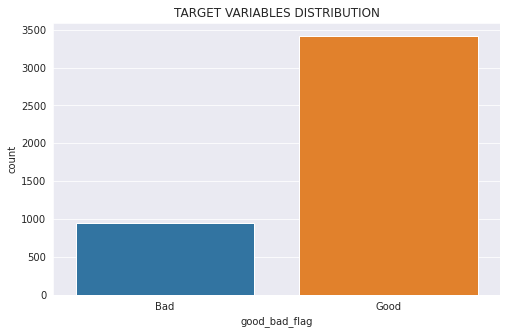

In [29]:
#PLOT TO SHOW THE VARIABLE TARGETED
sns.set_style('darkgrid')
plt.figure(figsize=(8, 5))
sns.countplot(train_data["good_bad_flag"])
plt.title('TARGET VARIABLES DISTRIBUTION')
plt.show()

In [30]:
# IDENTIFICATION OF MISSING DATA
train_data.isnull().sum().any(), test_data.isnull().sum().any() 

(False, False)

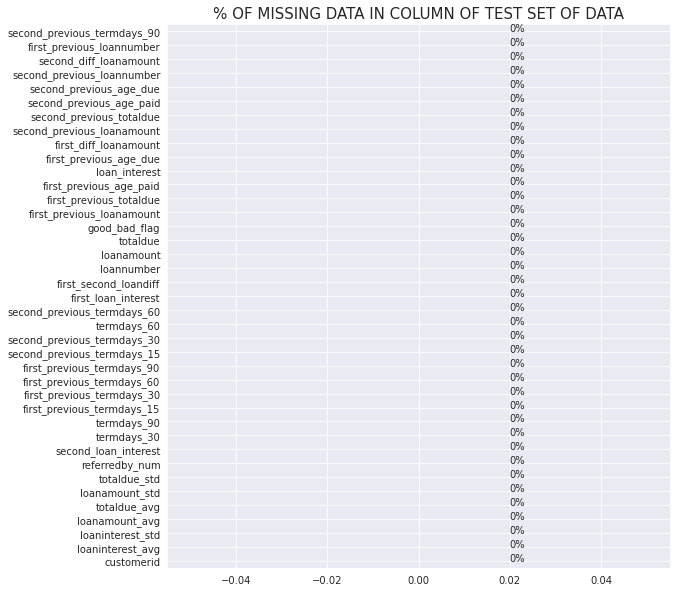

In [31]:
#FINDING MISSING DATA IN TRAIN
ax = train_data.isna().sum().sort_values().plot(kind = 'barh', figsize = (9, 10))
plt.title('% OF MISSING DATA IN COLUMN OF TEST SET OF DATA', fontdict={'size':15})
for p in ax.patches:
    percentage ='{:,.0f}%'.format((p.get_width()/train_data.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

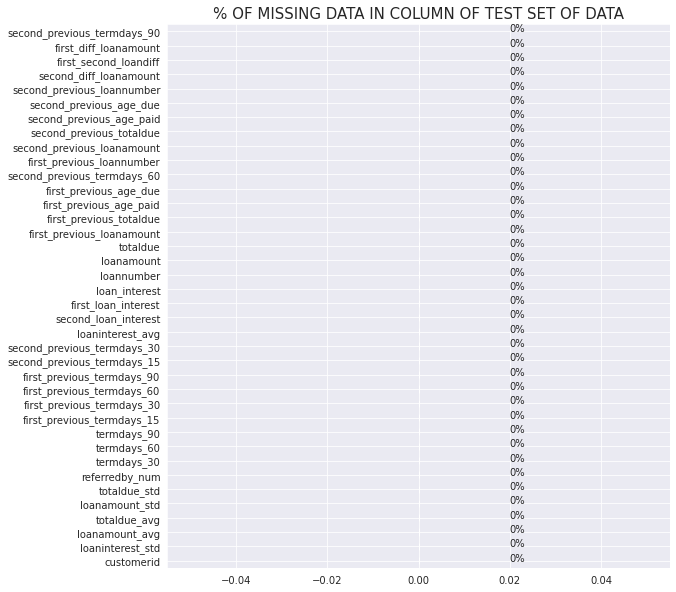

In [32]:
#FINDING MISSING DATA IN TEST 
ax = test_data.isna().sum().sort_values().plot(kind = 'barh', figsize = (9, 10))
plt.title('% OF MISSING DATA IN COLUMN OF TEST SET OF DATA', fontdict={'size':15})
for p in ax.patches:
    percentage ='{:,.0f}%'.format((p.get_width()/test_data.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

In [33]:
#DISPLAY TRAIN DATA INFO
print(train_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4368 entries, 0 to 4367
Data columns (total 39 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   customerid                   4368 non-null   object  
 1   loannumber                   4368 non-null   int64   
 2   loanamount                   4368 non-null   float64 
 3   totaldue                     4368 non-null   float64 
 4   good_bad_flag                4368 non-null   category
 5   first_previous_loanamount    4368 non-null   int64   
 6   first_previous_totaldue      4368 non-null   int64   
 7   first_previous_age_paid      4368 non-null   int64   
 8   first_previous_age_due       4368 non-null   int64   
 9   first_previous_loannumber    4368 non-null   int64   
 10  first_diff_loanamount        4368 non-null   float64 
 11  second_previous_loanamount   4368 non-null   int64   
 12  second_previous_totaldue     4368 non-null   int64   
 13  sec

In [34]:
#remove unique key systemloanid
train_data['good_bad_flag'] = train_data['good_bad_flag'].astype('category').cat.codes
test_data.fillna(0)
train_data.fillna(0)
test = test_data.iloc[: , 1:]
train = train_data.iloc[: , 1:]

In [35]:
test

,loannumber,loanamount,totaldue,first_previous_loanamount,first_previous_totaldue,first_previous_age_paid,first_previous_age_due,first_previous_loannumber,first_diff_loanamount,second_previous_loanamount,...,termdays_60,termdays_90,first_previous_termdays_15,first_previous_termdays_30,first_previous_termdays_60,first_previous_termdays_90,second_previous_termdays_15,second_previous_termdays_30,second_previous_termdays_60,second_previous_termdays_90
0,4,10000,12250.00000,10000,13000,500,1444,3,0,6000,...,0,0,0,1,0,0,1,0,0,0
1,10,40000,44000.00000,30000,36800,15,-4777,5,10000,30000,...,0,0,0,0,1,0,0,1,0,0
2,6,20000,24500.00000,10000,13000,15,694,3,10000,10000,...,0,0,0,1,0,0,1,0,0,0
3,8,30000,34500.00000,20000,22250,10,-194,6,10000,20000,...,0,0,1,0,0,0,1,0,0,0
4,4,20000,24500.00000,10000,13000,10,-4785,3,10000,10000,...,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1445,3,10000,11500.00000,10000,11500,10,-3042,2,0,10000,...,0,0,1,0,0,0,1,0,0,0
1446,3,10000,13000.00000,10000,11500,31,341,2,0,10000,...,0,0,1,0,0,0,1,0,0,0
1447,9,40000,48000.00000,25000,29000,15,-675,6,15000,10000,...,1,0,0,1,0,0,0,1,0,0
1448,14,60000,68100.00000,20000,23800,15,-39541,5,40000,50000,...,0,1,0,1,0,0,0,0,0,1


In [36]:
#IMPORTING THE USEFUL LIBRARIES
import os
import gc
import random
import pandas as pd
import numpy as np
import lightgbm as lgb
import xgboost as xgb
import seaborn as sns
from tqdm.notebook import tqdm
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt

from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold

import warnings
warnings.simplefilter('ignore')

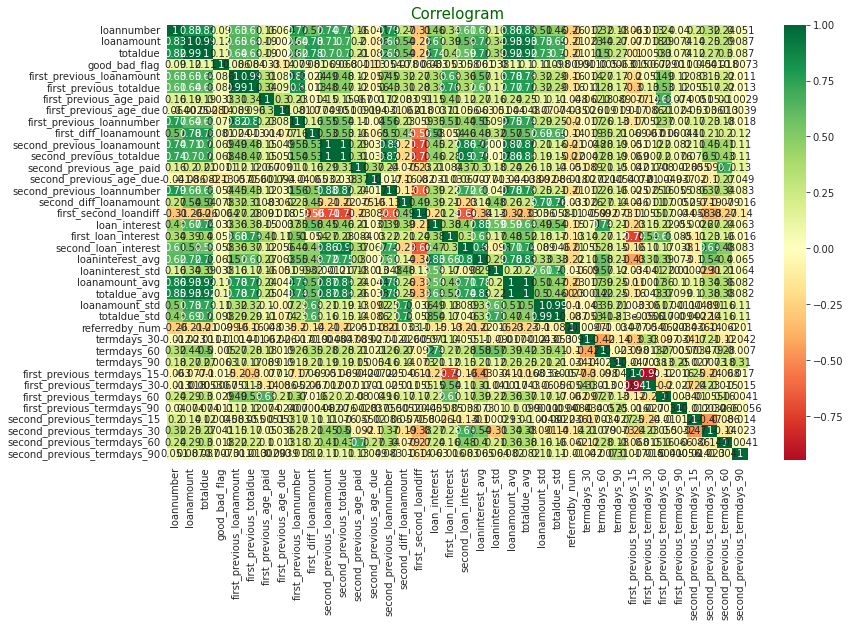

In [37]:
#QUANTIFY CORRELATION
corr = train.corr()
plt.figure(figsize = (13, 8))
sns.heatmap(corr, cmap='RdYlGn', annot = True, center = 0)
plt.title('Correlogram', fontsize = 15, color = 'darkgreen')
plt.show()

In [38]:
train.describe()

,loannumber,loanamount,totaldue,good_bad_flag,first_previous_loanamount,first_previous_totaldue,first_previous_age_paid,first_previous_age_due,first_previous_loannumber,first_diff_loanamount,...,termdays_60,termdays_90,first_previous_termdays_15,first_previous_termdays_30,first_previous_termdays_60,first_previous_termdays_90,second_previous_termdays_15,second_previous_termdays_30,second_previous_termdays_60,second_previous_termdays_90
count,4368.00000,4368.00000,4368.00000,4368.00000,4368.00000,4368.00000,4368.00000,4368.00000,4368.00000,4368.00000,...,4368.00000,4368.00000,4368.00000,4368.00000,4368.00000,4368.00000,4368.00000,4368.00000,4368.00000,4368.00000
mean,5.17239,17809.06593,21257.37768,0.78205,12975.96154,15709.37569,638.57143,-1767.83654,2.60485,4833.10440,...,0.06593,0.00733,0.35806,0.61538,0.02404,0.00046,0.22734,0.42674,0.02427,0.00069
std,3.65357,10749.69457,11943.51042,0.41290,6787.46801,7653.21994,4778.05951,17091.95811,2.40153,8171.63790,...,0.24820,0.08529,0.47948,0.48656,0.15319,0.02140,0.41916,0.49466,0.15390,0.02620
min,2.00000,10000.00000,10000.00000,0.00000,0.00000,0.00000,0.00000,-44913.00000,0.00000,-20000.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,2.00000,10000.00000,13000.00000,1.00000,10000.00000,11500.00000,10.00000,-7452.25000,1.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
50%,4.00000,10000.00000,13000.00000,1.00000,10000.00000,13000.00000,10.00000,-1948.00000,2.00000,0.00000,...,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
75%,7.00000,20000.00000,24500.00000,1.00000,10000.00000,13000.00000,15.00000,970.25000,3.00000,10000.00000,...,0.00000,0.00000,1.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000
max,27.00000,60000.00000,68100.00000,1.00000,50000.00000,57500.00000,101933.00000,505959.00000,20.00000,50000.00000,...,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000


In [39]:
#NOMALIZATION
def normalize(train, test): 
    mean, std = train.mean(), train.std() 
    train = (train - mean) / std 
    test = (test - mean) / std 
    return train, test 

In [40]:
#MODEL PREPARATION
class CFG :
  SEED = 100
  n_splits = 5
  lgb_params = {'boosting_type': 'gbdt','objective': 'binary','metric': 'auc',
                'n_estimators': 7000,'reg_lambda' : 140,'num_leaves' : 83,
                'seed': SEED,'early_stopping_rounds': 110,
               }
  remove_features = ['SplitBy' , 'folds', 'good_bad_flag','birthdate','bank_account_type', 'bank_name_clients', 'employment_status_clients', 'level_of_education_clients']
  remove_features_test = ['SplitBy' ,'testdemographics.COUNT(testperf)', 'folds', 'good_bad_flag','birthdate','bank_account_type', 'bank_name_clients', 'employment_status_clients', 'level_of_education_clients']
  TARGET_COL = ['good_bad_flag']
class CostumSplit :
  def __init__(self,) :
    self.n_splits = CFG.n_splits

  def Split(self,Train_) :
    kf = GroupKFold(n_splits=self.n_splits)

    Train = Train_.copy()
    Train = Train.drop_duplicates('SplitBy').reset_index(drop=True)
    
    groups = Train['SplitBy']
    Train["folds"]=-1   
    for fold, (_, val_index) in enumerate(kf.split(Train,Train['good_bad_flag'],groups)):
          Train.loc[val_index, "folds"] = fold
    return Train

  def apply(self,train) :
    mapper = dict(zip(self.Split(train)['SplitBy'].tolist(),self.Split(train)['folds'].tolist()))

    train['folds'] = train['SplitBy'].map(mapper)
    return train
train['SplitBy']   = train['loannumber']
train = train.sort_values('SplitBy').reset_index(drop=True)
train['good_bad_flag'] = train['good_bad_flag'].astype('category').cat.codes
split = CostumSplit() 
train = split.apply(train)
features_columns_train = [col for col in train.columns if col not in CFG.remove_features]
features_columns_test = [col for col in test.columns if col not in CFG.remove_features_test]

#DISPLAY TEST FEATURES COLUMN
len(features_columns_test)

37

In [41]:
#DISPLAY TRAIN FEATURES COLUMN
len(features_columns_train)

37

In [42]:
#CROSS VALIDATION USING RANDOMFOREST
#KFOLD TRAINING
from sklearn.ensemble import GradientBoostingClassifier
oof_lgb = np.zeros((train.shape[0],))
test[CFG.TARGET_COL] = 0
lgb_preds = []
xgb.set_config(verbosity=0)

for fold in range(CFG.n_splits) :
    print(50*'-')
    print(f'Fold {fold+1} / {CFG.n_splits}' )

    tr_x, tr_y = train[train['folds']!=fold][features_columns_train] , train[train['folds']!=fold][CFG.TARGET_COL] 
    vl_x, vl_y = train[train['folds']==fold][features_columns_train] , train[train['folds']==fold][CFG.TARGET_COL] 
    
    val_idx = vl_x.index.tolist()
   
    estimator = RandomForestClassifier(random_state= 28, n_estimators=150, max_features= 'log2', max_depth= 9, bootstrap= True)
  
    estimator.fit(tr_x,tr_y)
    y_pred_val = estimator.predict(vl_x)
    oof_lgb[val_idx] = y_pred_val
    print(f'FOLD-{fold+1} accuracy score :',accuracy_score(vl_y, y_pred_val))

    y_pred_test = estimator.predict(test[features_columns_test])
    lgb_preds.append(y_pred_test)
    print(50*'-')

print('OOF Error :',(1 - accuracy_score(train[CFG.TARGET_COL], (oof_lgb>0.5)*1)))

--------------------------------------------------
Fold 1 / 5
FOLD-1 accuracy score : 0.8089005235602095
--------------------------------------------------
--------------------------------------------------
Fold 2 / 5
FOLD-2 accuracy score : 0.8148148148148148
--------------------------------------------------
--------------------------------------------------
Fold 3 / 5
FOLD-3 accuracy score : 0.6829908176650634
--------------------------------------------------
--------------------------------------------------
Fold 4 / 5
FOLD-4 accuracy score : 0.792341678939617
--------------------------------------------------
--------------------------------------------------
Fold 5 / 5
FOLD-5 accuracy score : 0.8520499108734403
--------------------------------------------------
OOF Error : 0.2534340659340659


                         customerid  good_bad_flag
0  8a858899538ddb8e015390510b321f08              1
1  8a858959537a097401537a4e316e25f7              1


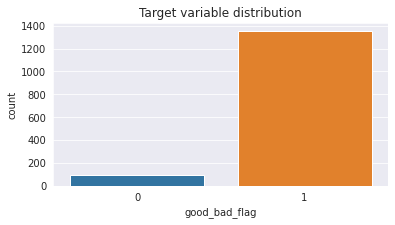

1357
93


In [43]:
#SUBMISSION CSV FILE
submission_file_name = 'fikirism_sub.csv' ;
sub_df = testperf[['customerid']].copy() ; 
sub_df['good_bad_flag'] = (np.mean(lgb_preds,axis=0)>0.5)*1
sub_df.to_csv(submission_file_name, index=False)
print(sub_df.head(2))

#PLOT TO SHOW THE VARIABLE TARGETED
sns.set_style('darkgrid')
plt.figure(figsize=(6, 3))
sns.countplot(sub_df["good_bad_flag"])
plt.title('Target variable distribution')
plt.show()
print(sub_df[sub_df['good_bad_flag'] == 1]['customerid'].count())
print(sub_df[sub_df['good_bad_flag'] == 0]['customerid'].count())

In [44]:
#This code made to be at 06 place on competition leaderboard with 0.2089655172413793 score.